[0. 0. 0. ... 0. 0. 0.]


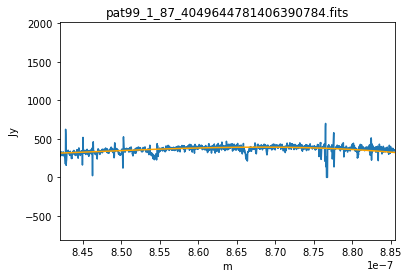

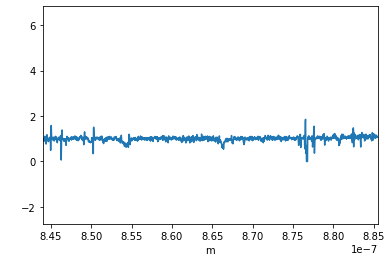

 SP_Ace version v1.4
 Copyright (C) 2020 Corrado Boeche
 This program comes with ABSOLUTELY NO WARRANTY.
 This is free software, and you are welcome to redistribute it
 under certain conditions; see <http://www.gnu.org/licenses/> for details.
 spectrum: /home/smu/Carlos/n6569/normalized/pat99_1_87_4049644781406390784.fits_norm.out                                          
 TGM norm. loop      1  Teff= 4890 log g= 2.58 [M/H]=-0.16
 TGM norm. loop      2  Teff= 4547 log g= 2.77 [M/H]=-0.37
 TGM norm. loop      3  Teff= 4584 log g= 2.82 [M/H]=-0.27
 TGM norm. loop      4  Teff= 4558 log g= 2.88 [M/H]=-0.29
 TGM norm. loop      5  Teff= 4577 log g= 2.87 [M/H]=-0.26
 TGM norm. loop      6  Teff= 4568 log g= 2.92 [M/H]=-0.27
 TGM norm. loop      7  Teff= 4576 log g= 2.91 [M/H]=-0.26
 TGM outer loop      1  Teff= 4555 log g= 3.01 [M/H]=-0.25
 TGM outer loop      2  Teff= 4546 log g= 3.00 [M/H]=-0.26
 ABD loop
 TGM outer loop      3  Teff= 4491 log g= 2.82 [M/H]=-0.20
 TGM outer loop      4  T

In [4]:
from astropy.io import fits
import numpy as np
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
quantity_support()  # for getting units on the axes below  
from astropy import units as u #units
import astropy.wcs as fitswcs #wcs
from specutils import Spectrum1D, SpectralRegion #spectrum1D (specutils)
from specutils.fitting import fit_generic_continuum

import warnings
import astropy.units as u
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.fitting import LevMarLSQFitter
import pandas as pd
import subprocess

i = 0
j = 0
test = []


stars = pd.read_csv("/home/smu/Carlos/Spectra_for_Evan_Butler/p99_giants_forCarlos.dat", delimiter=',')
#stars = pd.read_csv("/home/smu/Carlos/n6569/archive/requested_files.txt", delimiter=',') 

header = stars.head()

spec_name = stars['Fibre_#']
spec_vel = stars['RV']


for i in range(0, 1): #len(spec_name)):        
    warnings.simplefilter('ignore')    
    
    
    spec_path = "/home/smu/Carlos/Spectra_for_Evan_Butler/FITS_P99_GIANTS/" + spec_name[i] 
    #spec_path = "/home/smu/Carlos/n6569/N6569_2_ccd2/FITS_FILES/n6569_2_" + str(spec_name[i]) + ".fits" # for Joanne

    file = fits.open(spec_path)
    specdata = file[0].data
    header = file[0].header
    print(specdata)
    #open & load spectrum file


    #make WCS object
    wcs_data = fitswcs.WCS(header={'CDELT1': header['CDELT1'], 'CRVAL1': header['CRVAL1'],
                               'CUNIT1': header['CUNIT1'], 'CTYPE1': 'WAVE',
                               'CRPIX1': header['CRPIX1']})


    flux= specdata * u.Jy


    spec = Spectrum1D(flux=flux, wcs=wcs_data)

    l0 = 8.498018E-7 ## m
    cc = 299792.458 ## speed of light : km/second

    vel = spec_vel[i] ## km/s


    lambda_shift = ((vel/cc * l0)) ## units of meters
    
    lambda_shift_A = ((vel/cc * l0)) * 10000000000 ## units of Angstroms
    
    x = (spec.spectral_axis - lambda_shift * u.m)
    xA = (spec.spectral_axis - lambda_shift * u.m) * 10000000000.0
    y = spec.flux

    spectrum = Spectrum1D(flux = y, spectral_axis = x)

    
    with warnings.catch_warnings():
        
        g1_fit = fit_generic_continuum(spectrum, median_window=3, model=Polynomial1D(3), fitter=LevMarLSQFitter(), 
                                   exclude_regions=[SpectralRegion(0.7 * u.um, 0.845 * u.um), SpectralRegion(0.8493 * u.um, 0.8503 * u.um),
                                                    SpectralRegion(0.8535 * u.um, 0.855 * u.um),SpectralRegion(0.866 * u.um, 0.867 * u.um),SpectralRegion(0.88 * u.um, 0.90 * u.um)], weights=None)
 
    plt.plot(x,y)
    plt.title(spec_name[i])
    plt.xlim([8.420E-7,8.855E-7])
    plt.plot(x,g1_fit(x), color = 'orange')
    plt.show()
    
    spec_normalized = y / g1_fit(x)
   
    plt.plot(x,spec_normalized)
    plt.xlim([8.44E-7,8.855E-7])
    plt.show()

    
    with open ('/home/smu/Carlos/n6569/normalized/' + str(spec_name[i]) + '_norm.out','w') as f:
        for j in range(0, len(xA)):
            f.write(' ' + str(xA[j].value) + ' ' + str(spec_normalized[j]) + '\n')
    
  
            
    with open ('/home/smu/Carlos/SPACE/par_files/' + str(spec_name[i]) + '.par','w') as ff:
        
            ff.write("obs_sp_file '/home/smu/Carlos/n6569/normalized/" + str(spec_name[i]) + "_norm.out'\n")
            ff.write("#\n")
            ff.write("GCOGlib '/home/smu/Carlos/SPACE/GCOG_library_v1.0/'\n")
            ff.write("#\n")
            ff.write("fwhm 0.8\n")
            ff.write("#\n")
            ff.write("alpha\n")
            ff.write("#\n")            
            #ff.write("wave_lims 8500 8855\n") # Full
            #ff.write("wave_lims 8505 8535 8547 8660 8670 8702\n") # Koch
            #ff.write("wave_lims 8450 8493 8503 8535 8550 8660 8670 8800\n") # Campos
            #ff.write("wave_lims 8450 8490 8505 8535 8550 8655 8670 8750 8798 8813\n") # Delta
            ff.write("wave_lims 8420 8850\n") # Joanne
            ff.write("#\n")
            ff.write("#\n")
            ff.write("error_est\n")
            ff.write("#\n")
            ff.write("null_value 'NaN'\n")
            
    executable_path = "/home/smu/Carlos/SPACE/./SPACE-1.4a"
            
    arg2 = "/home/smu/Carlos/SPACE/par_files/" + str(spec_name[i]) + ".par"   
    
    subprocess.run([executable_path, arg2])
    
    '''    
    awk_command = "awk 'NR==2 {print FILENAME} NR >1' /home/smu/Carlos/SPACE/par_files/" + str(spec_name[i]) + "_TGM_ABD.dat > test"
    output = subprocess.check_output(awk_command, shell=True)
    print(output.decode())
    awk_command = "awk 'ORS=NR%2?FS:RS' < test > /home/smu/Carlos/SPACE/test1"
    output = subprocess.check_output(awk_command, shell=True)
    print(output.decode())
    awk_command = "awk '{gsub(/\/home\/smu\/Carlos\/SPACE\/par_files\//,\"\")}; 1' < /home/smu/Carlos/SPACE/test1 > /home/smu/Carlos/SPACE/test"
    output = subprocess.check_output(awk_command, shell=True)
    print(output.decode())
    awk_command = "awk '{gsub(/_TGM_ABD.dat/,\"\")}; 1' < /home/smu/Carlos/SPACE/test > /home/smu/Carlos/SPACE/out_files/" + str(spec_name[i]) + ".out"
    output = subprocess.check_output(awk_command, shell=True)
    print(output.decode())

command = "cat /home/smu/Carlos/SPACE/out_files/*.out > /home/smu/Carlos/n6569/test.out"
output = subprocess.check_output(command, shell=True)
print(output.decode())
'''

           